# Train Object Colors

In [1]:
from collections import namedtuple
from IPython.display import display

import numpy as np


import matplotlib.pyplot as plt

import torch
import source.tensorize as t
import torch.optim as optim 
import torch.nn.functional as F
from source.scene import *
from source.renderer import *

%load_ext autoreload
%autoreload 2

### Ground Truth and Initial Guess

Remember the trainable quantities are the scene parameters.  

In [2]:
experiment = 'color_test_2'
true_scene = parse_scene('./scenes/%s.ground_truth.yaml' % experiment)
pred_scene = parse_scene('./scenes/%s.init1.yaml' % experiment)


Now create the images and display the initialization:

In [3]:
true_renderer = FlatRenderer(true_scene)
true_image = true_renderer.forward()
true_image.show_image('albedo', title='Ground Truth', subplot='121')

pred_renderer = FlatRenderer(pred_scene)
pred_renderer.set_trainable({'tri_1': ['color'], 'ball_middle': ['color'], 'ball_right': ['color'], 'ball_front': ['color'], 'ball_up': ['color']})
pred_image = pred_renderer.forward()
pred_image.show_image('albedo', title='Initial Guess', subplot='122')
plt.show()
          

### Todo: A smart loss function for the camera parameters...

In [4]:
params  = list(filter(lambda p: p.requires_grad, pred_renderer.parameters()))
print(params)
optimizer = optim.Adam(params, lr=0.1)

[Parameter containing:
tensor([0.7307, 0.4816, 0.4122], requires_grad=True), Parameter containing:
tensor([0.6054, 0.5296, 0.7145], requires_grad=True), Parameter containing:
tensor([0.7310, 0.5273, 0.2702], requires_grad=True), Parameter containing:
tensor([0.5139, 0.5597, 0.3492], requires_grad=True), Parameter containing:
tensor([0.0930, 0.2589, 0.6999], requires_grad=True)]


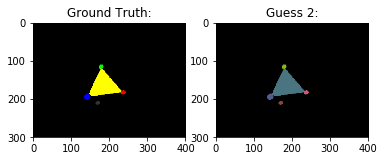

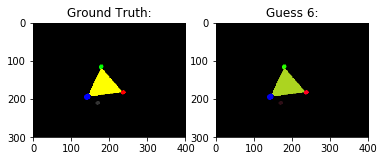

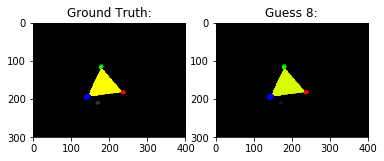

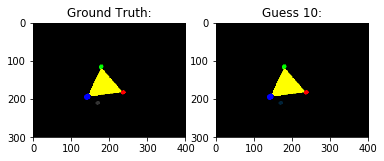

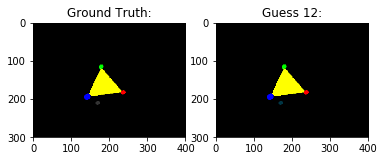

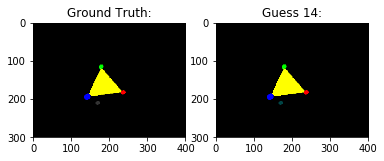

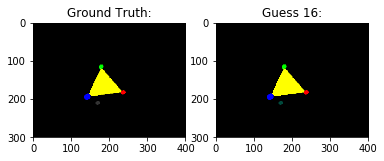

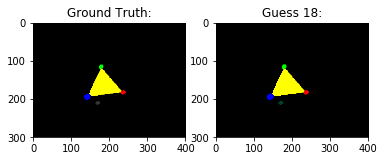

In [5]:
iterations = 20
loss_history = []
radius_history = []
for _ in range(iterations):
    
    pred_renderer.clear()
    optimizer.zero_grad()
    
    pred_image = pred_renderer.forward()
    loss = F.mse_loss(true_image.get_image('albedo'), pred_image.get_image('albedo'))
    loss.backward()
    optimizer.step()

    
    #history of intermediate losses and images 
    loss_history.append(t.detach_numpy(loss))
    
    if _ % (iterations/10) == 0:
        true_pos = t.detach_numpy(true_renderer.camera['position'])
        pred_pos = t.detach_numpy(pred_renderer.camera['position'])

        true_image.show_image('albedo', title='Ground Truth:', subplot='121')
        pred_image.show_image('albedo', title='Guess {0}:'.format(_), subplot='122')
        plt.show()
    
    
_ = np.arange(iterations)
plt.plot(_, loss_history, label='loss')
plt.xticks(_)
plt.legend()
plt.show()


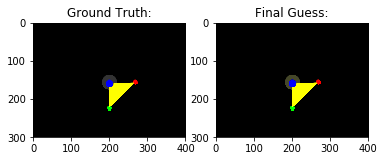

In [6]:
true_image.show_image('albedo', title='Ground Truth:', subplot='121')
pred_image.show_image('albedo', title='Final Guess:', subplot='122')
plt.show()